# Retinal Vlood Vessel Segmentation

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import filters, exposure, morphology, feature, util, measure
from skimage.morphology import disk
from skimage.filters import frangi, laplace
from skimage.morphology import reconstruction, skeletonize, remove_small_objects

In [21]:
img_bgr = cv2.imread("../image.jpg", cv2.IMREAD_GRAYSCALE)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img = cv2.resize(img_rgb, (512, 512), interpolation=cv2.INTER_AREA)

selem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25,25))

In [32]:
# Top-hat et Bottom-hat
opened = cv2.morphologyEx(img, cv2.MORPH_OPEN, selem)
closed = cv2.morphologyEx(img, cv2.MORPH_CLOSE, selem)

tophat = cv2.subtract(img, opened)
bothat = cv2.subtract(closed, img)

# Rehaussement du contraste global
enhanced = cv2.add(img, tophat)
enhanced = cv2.subtract(enhanced, bothat)

# Normalisation
enhanced = cv2.normalize(enhanced, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


small_selem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))

# Opening = suppression du bruit clair isolé
opened = cv2.morphologyEx(enhanced, cv2.MORPH_OPEN, small_selem)

# Closing = comblement de petits trous dans les vaisseaux
cleaned = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, small_selem)

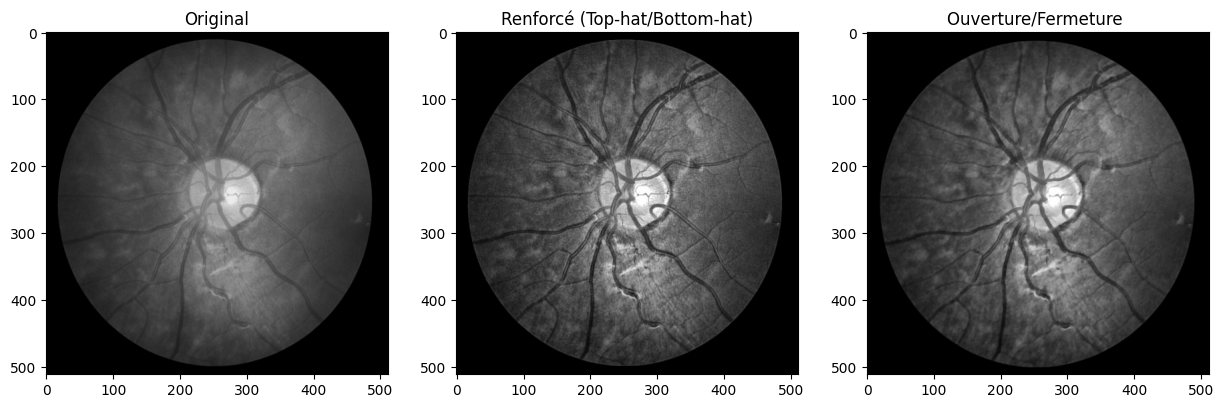

In [33]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title('Original')
plt.subplot(1,3,2); plt.imshow(enhanced, cmap='gray'); plt.title('Renforcé (Top-hat/Bottom-hat)')
plt.subplot(1,3,3); plt.imshow(cleaned, cmap='gray'); plt.title('Ouverture/Fermeture ')
plt.show()

In [6]:
def show_list(imgs, titles, cmap='gray', figsize=(16,6)):
    n = len(imgs)
    plt.figure(figsize=figsize)
    for i, (im, t) in enumerate(zip(imgs, titles), 1):
        plt.subplot(1, n, i)
        plt.imshow(im, cmap=cmap)
        plt.title(t)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
def make_line_se(length=15, angle=0):
    # create horizontal line
    se = np.zeros((length, length), dtype=np.uint8)
    center = length // 2
    se[center, :] = 1
    # rotate around center
    M = cv2.getRotationMatrix2D((center, center), angle, 1.0)
    rotated = cv2.warpAffine(se.astype(np.uint8)*255, M, (length, length))
    return (rotated > 128).astype(np.uint8)

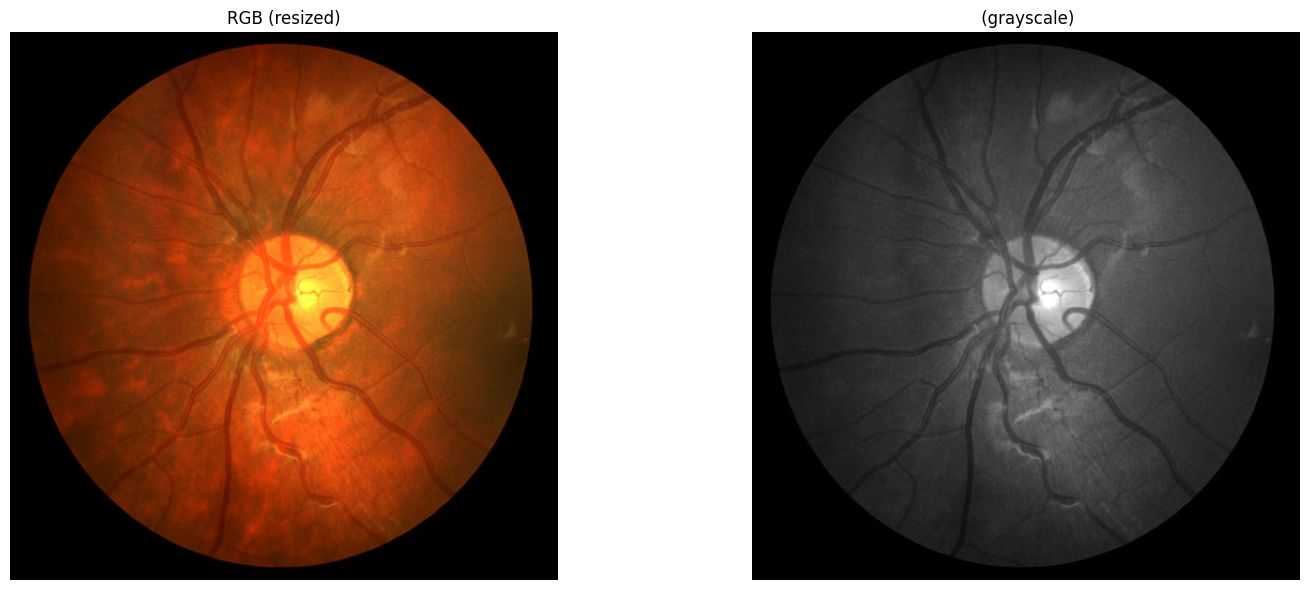

In [24]:
img_path = "../image.jpg"     # change path if needed
img_color = cv2.imread(img_path, cv2.IMREAD_COLOR)   # BGR
if img_color is None:
    raise FileNotFoundError(f"Could not read {img_path}")

# convert to RGB for display
img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
# resize to (512, 512)
img_rgb = cv2.resize(img_rgb, (512, 512), interpolation=cv2.INTER_AREA)

# choose green channel (best vessel contrast typically)
img_gray = img_rgb[..., 1]   # green channel
img_gray = img_gray.astype(np.uint8)

show_list([img_rgb, img_gray], ['RGB (resized)', ' (grayscale)'])

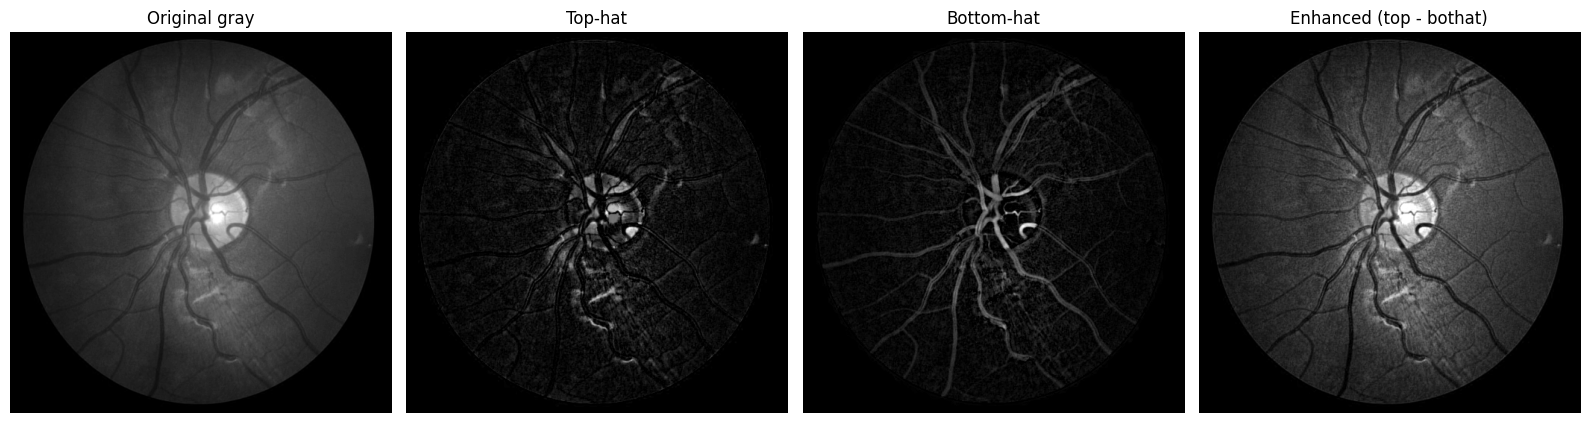

In [ ]:
# Use disk SE tuned to vessel widths
se_tophat = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))  # adjust (15,15)
opened_cv = cv2.morphologyEx(img_gray, cv2.MORPH_OPEN, se_tophat)
closed_cv = cv2.morphologyEx(img_gray, cv2.MORPH_CLOSE, se_tophat)

tophat = cv2.subtract(img_gray, opened_cv)     # white top-hat
bothat = cv2.subtract(closed_cv, img_gray)     # black top-hat (bottom-hat)

# combine: amplify vessels while reducing center reflexs
enh = cv2.add(img_gray, tophat)                # add bright structures
enh = cv2.subtract(enh, bothat)                # reduce dark-background artifacts
enh = cv2.normalize(enh, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

show_list([img_gray, tophat, bothat,enh],
          ['Original gray', 'Top-hat', 'Bottom-hat', 'Enhanced (top - bothat)'], figsize=(16,6))

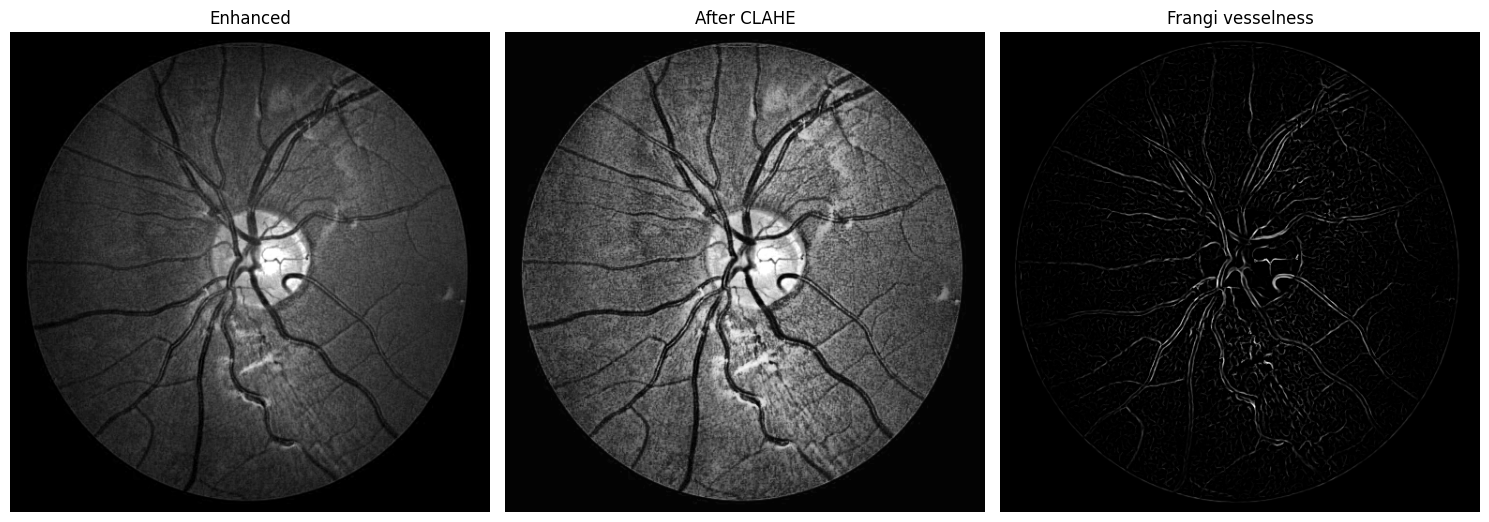

In [14]:
# CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enh_clahe = clahe.apply(enh)

# Frangi vesselness (skimage) expects float in [0,1]
frangi_map = frangi(enh_clahe / 255.0, sigmas=(1,8), scale_step=2, black_ridges=True)
frangi_norm = (255 * (frangi_map - frangi_map.min()) / (np.ptp(frangi_map) + 1e-9)).astype(np.uint8)

show_list([enh, enh_clahe, frangi_norm], ['Enhanced', 'After CLAHE', 'Frangi vesselness'], figsize=(15,6))

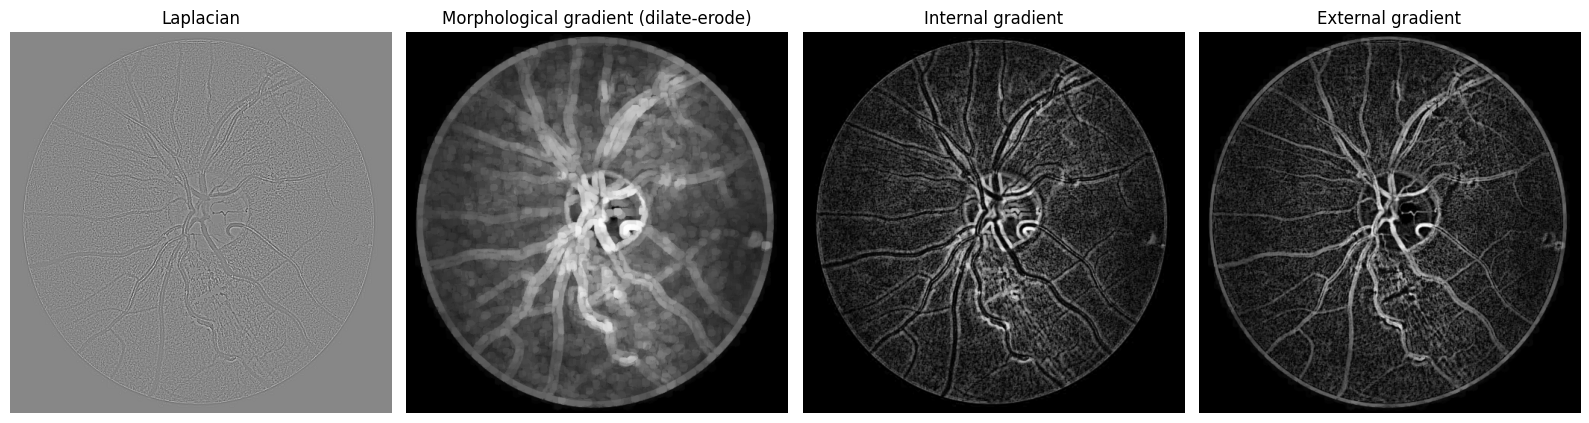

In [18]:
# Laplacian (edge / high-frequency emphasis)
lap = laplace(enh_clahe.astype(float)/255.0)
lap = (255 * (lap - lap.min()) / (np.ptp(lap) + 1e-9)).astype(np.uint8)

# morphological gradient using small SE (dilate - erode)
se_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,10))
dil = cv2.dilate(enh_clahe, se_small, iterations=1)
er = cv2.erode(enh_clahe, se_small, iterations=1)
morph_grad = cv2.subtract(dil, er)

# internal gradient (image - erode) and external gradient (dilate - image)
internal_grad = cv2.subtract(enh_clahe, er)
external_grad = cv2.subtract(dil, enh_clahe)

show_list([lap, morph_grad, internal_grad, external_grad],
          ['Laplacian', 'Morphological gradient (dilate-erode)', 'Internal gradient', 'External gradient'],
          figsize=(16,8))

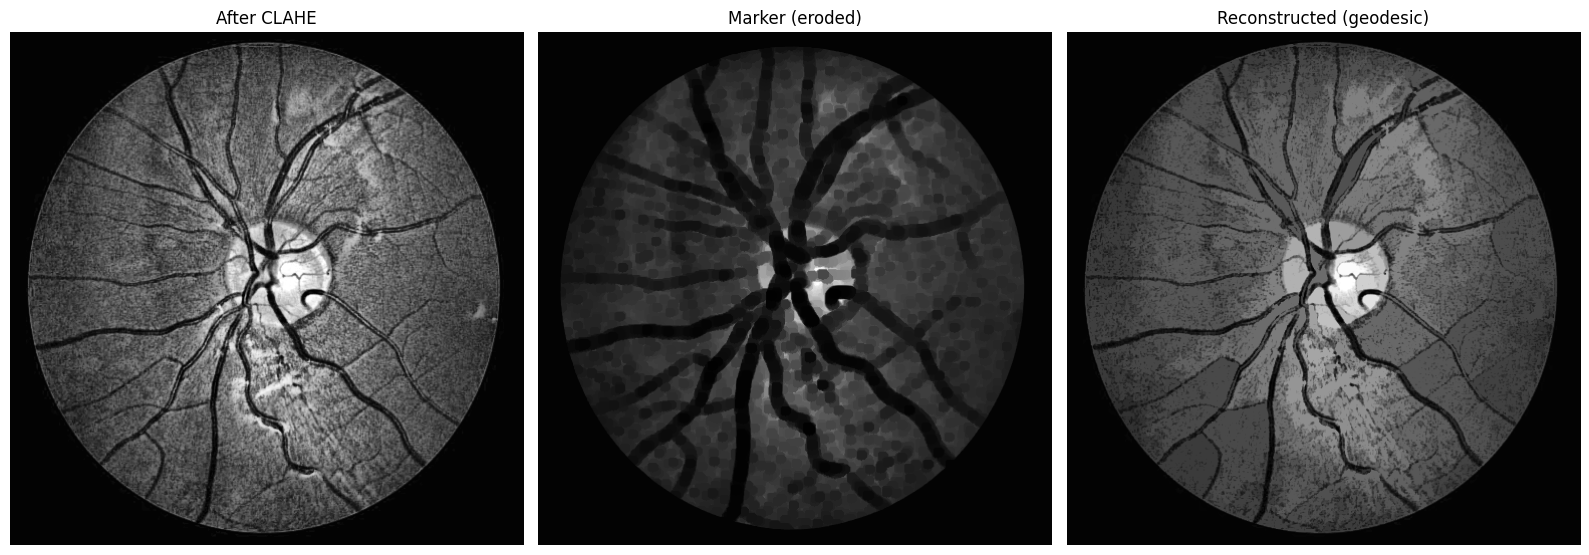

In [20]:
# marker-based reconstruction: subtract a smoothed/opened image to get markers, then reconstruct
# create mask = enhanced image, marker = opened (eroded) variant
marker = cv2.erode(enh_clahe, se_small, iterations=1)
mask = enh_clahe.copy()
reconstructed = reconstruction(marker.astype(np.uint8), mask.astype(np.uint8), method='dilation')
reconstructed = reconstructed.astype(np.uint8)

# show comparison
show_list([enh_clahe, marker, reconstructed], ['After CLAHE', 'Marker (eroded)', 'Reconstructed (geodesic)'])

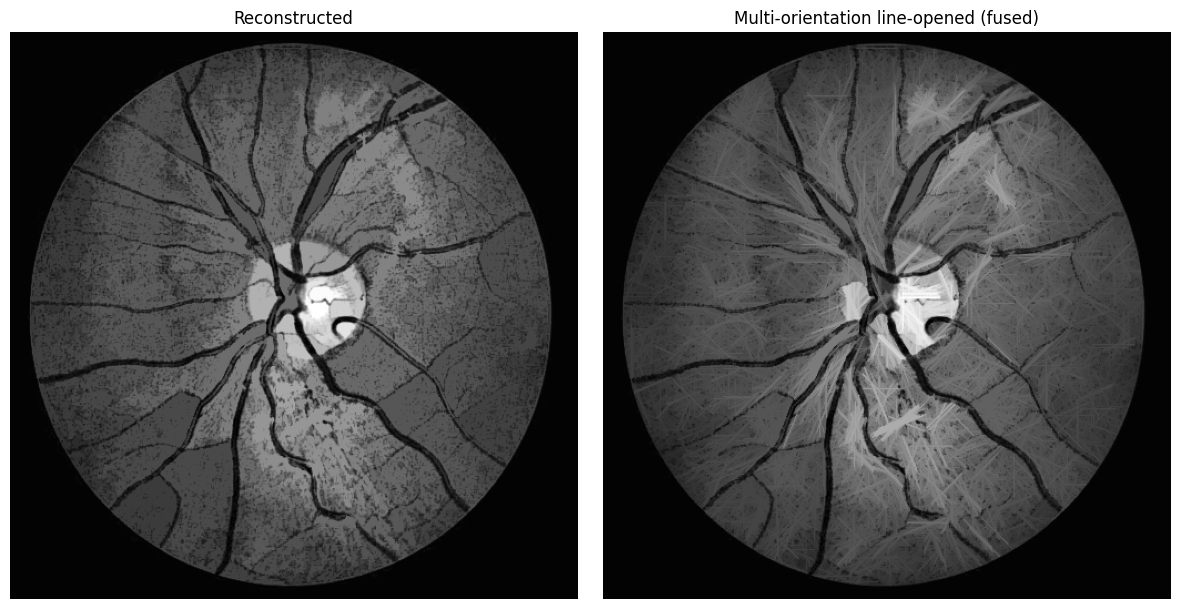

In [25]:
# Apply line opening at several angles and take maximum response (morphological multiscale/orientation)
angles = np.arange(0, 180, 22.5)   # 8 orientations
length = 31                        # length of line SE, tune per image scale
responses = []
for a in angles:
    se_line = make_line_se(length=length, angle=a)  # uint8 kernel
    # apply opening using cv2 (needs kernel as uint8)
    opened_line = cv2.morphologyEx(reconstructed, cv2.MORPH_OPEN, se_line.astype(np.uint8))
    responses.append(opened_line)

# fuse responses by taking maximum across orientations
multi_orient = np.maximum.reduce(responses)

show_list([reconstructed, multi_orient], ['Reconstructed', 'Multi-orientation line-opened (fused)'], figsize=(12,6))